<a href="https://colab.research.google.com/github/AAhmadS/deeplearning-HW4/blob/main/NLP_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torchtext==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1


In [ ]:
import pandas as pd
import numpy as np
from numpy import pad
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import torch
from torch import nn
import torchtext
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import Counter
from torchtext.data.utils import get_tokenizer
import nltk
from nltk.tokenize import sent_tokenize
from transformers import pipeline, AutoTokenizer
from __future__ import unicode_literals, print_function, division
from torch import optim
import torch.nn.functional as F
import random

from tqdm import tqdm

#Section 1 : Loading data and preprocessing


In [424]:
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [425]:
with open("ferdousi.txt","r") as fle:
  file = fle.read().splitlines()[2:]

In [426]:
sentences = [tokenizer.tokenize(x) for x in file]

In [427]:
tokenized = [tokenizer.convert_tokens_to_ids(x) for x in sentences]

In [428]:
sentences[0]

['▁به', '▁نام', '▁خداوند', '▁جان', '▁و', '▁خرد']

In [429]:
max_len=0
max_num=0
for x in tokenized:
  if(max_len<len(x)):max_len = len(x)
  if(max(x)>max_num):
    max_num = max(x)
print(max_len, max_num)

14 24999


In [430]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
# device=torch.device("cpu")

Using cuda for inference


In [431]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {'[BOP]':10, '<unk>':0, tokenizer.eos_token : tokenizer.eos_token_id, tokenizer.bos_token : tokenizer.bos_token_id}
        self.word2count = {}
        self.index2word = {tokenizer.bos_token_id: tokenizer.bos_token, tokenizer.eos_token_id: tokenizer.eos_token, 10:'[BOP]', 0:'<unk>'}
        self.n_words = 25000 

    def addSentence(self, sentences, tokenized):
        for i in range(len(sentences)):
          for j in range(len(sentences[i])):
            self.addWord(sentences[i][j],tokenized[i][j])

    def addWord(self, word, index):
        if word not in self.word2index:
            self.word2index[word] = index
            self.word2count[word] = 1
            self.index2word[index] = word
        else:
            self.word2count[word] += 1

In [432]:
po_persian = Lang("persian")
po_persian.addSentence(sentences,tokenized)

In [433]:
input_lang = po_persian
output_lang = po_persian
SB_token = '[BOP]'
SB_token_id = 10
WSpace_token_id=0
sentences
tokenized
Global_pad_arg = 14

def indexesFromSentence(lang, sentence_ind):
    return [lang.word2index[word] for word in sentences[sentence_ind]]


def tensorFromSentence(lang, sentence_ind, pad_arg, code=0):
    indexes = indexesFromSentence(lang, (sentence_ind)%99217)
    while len(indexes)<pad_arg:
      indexes.append(WSpace_token_id)
    if code ==1 :
      indexes.append(tokenizer.eos_token_id)
    else:
      indexes.append(SB_token_id)
    return torch.tensor(indexes, dtype=torch.int32).view(-1, 1)


def tensorsFromPair(pair_ind):
    input_tensor = torch.cat((tensorFromSentence(input_lang, 2*pair_ind, 14),tensorFromSentence(input_lang,2*pair_ind+1,14,code=1)))
    target_tensor = torch.cat((tensorFromSentence(output_lang,2*pair_ind+2, 14),tensorFromSentence(output_lang, 2*pair_ind+3, 14,code=1)))
    return np.array(input_tensor), np.array(target_tensor)

In [434]:
train_data = np.array([tensorsFromPair(x) for x in range(49608)])

In [438]:
X = train_data[:,0,:].reshape((49608,30))
y = train_data[:,1,:].reshape((49608,30))

X = torch.from_numpy(X)
y = torch.from_numpy(y)

train_dataset = TensorDataset(X, y)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#Section 2 : LSTM model

##Training Subsection:

In [437]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True).reshape(y.size())
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [439]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Encoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)

  def forward(self, input):
    embedding = self.dropout(self.embedding(input))
    output, (hidden, cell) = self.lstm(embedding)

    return hidden, cell


class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
    self.fc = nn.Linear(hidden_size, input_size)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)

    embedding = self.dropout(self.embedding(input))
    output, (hidden, cell) = self.lstm(embedding,(hidden,cell))
    prediction = self.softmax(self.fc(output))
    prediction = prediction.squeeze(0)

    return prediction, hidden, cell 


class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input, target, teacher_force_ratio=0.5, vocab_size=25000):
    batch_size = input.shape[1]
    target_len  = target.shape[0]

    outputs = torch.zeros(target_len, batch_size, vocab_size, device=device)

    hidden, cell = self.encoder(input)

    x = torch.ones_like(target[0] , device=device)*8

    for t in range(0, target_len):
      output, hidden, cell = self.decoder(x, hidden, cell)
      
      outputs[t] = output

      best_guess = output.argmax(dim=1)

      x = target[t] if random.random()<teacher_force_ratio else best_guess

    return outputs


In [440]:
num_epochs = 5
learning_rate=1e-3
batch_size=1
input_size = po_persian.n_words
embedding_size = 128
hidden_size = 128
num_layers = 2
dropout=0.5

In [441]:
encoder1 = Encoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)
decoder1 = Decoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)

model = Seq2Seq(encoder1, decoder1)

In [442]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, capturable=True)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [443]:
losses = []
accs = []
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
      for i,(X, y) in pbar:
          count+=1
          X = X.T.to(device)
          y = y.T.type(torch.LongTensor).to(device)

          optimizer.zero_grad()
          outputs = model(X,y)
          outputs = outputs[1:].reshape(-1,outputs.shape[2])
          y = y[1:].reshape(-1)


          loss = criterion(outputs, y)
          acc = calculate_accuracy(outputs, y)
          accuracy += acc
          epoch_loss += loss

          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
          optimizer.step()

          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f} - Accuracy: {accuracy*100/(i+1):.4f}%')

          if(count>5000):break
      losses.append((epoch_loss/len(pbar)).cpu().item())
      accs.append((accuracy*100/len(pbar)).cpu().item())
      if (losses[-1]==min(losses)):
          torch.save(model.state_dict(), 'Ferdousi_lstm.pth')

EPOCH:5 - Loss: 9.9465 - Accuracy: 8.6630%: 100%|██████████| 776/776 [01:43<00:00,  7.47it/s]


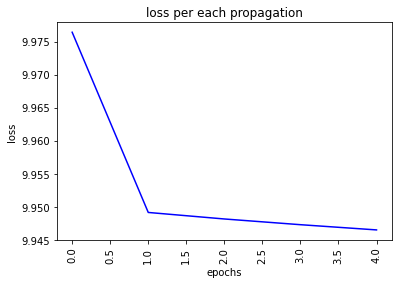

In [444]:
plt.plot(losses, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per each propagation")
plt.show()

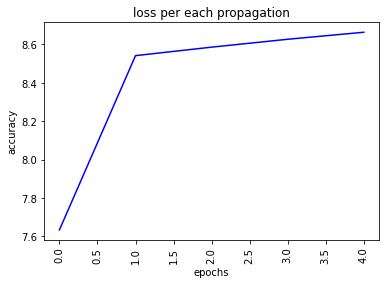

In [445]:
plt.plot(accs, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("loss per each propagation")
plt.show()

##generation

In [446]:
X1 = train_data[:,0,:].reshape((49608,30))
y1 = train_data[:,1,:].reshape((49608,30))

X1 = torch.from_numpy(X1)
y1 = torch.from_numpy(y1)

train_dataset1 = TensorDataset(X1, y1)
train_dataloader1 = DataLoader(train_dataset1, batch_size=1, shuffle=True)

In [447]:
m= ["چو آفتاب روز آمدش بر میان","پدیدار شد رزم آن شیردلان"]
m[0],m[1] = tokenizer.tokenize(m[0]), tokenizer.tokenize(m[1])

In [448]:
m[0],m[1] = np.array(tokenizer.convert_tokens_to_ids(m[0])),np.array(tokenizer.convert_tokens_to_ids(m[1]))

In [449]:
n = np.concatenate((m[0],[0,0,0,0,0,0,0,15],m[1],[0,0,0,0,0,0,0,0,9]))

In [450]:
model.eval()
outputs = model(torch.tensor(n.reshape(30,1),device=device),torch.tensor(n.reshape(30,1),device=device),teacher_force_ratio=0.0)
outputs = torch.argmax(outputs.reshape(30,25000),dim = 1)
print(tokenizer.decode(outputs))

و و و و و و و و و و و و و[BOP][BOP][BOP][BOP][BOP][BOP][BOP][BOP][BOP][BOP] و و و و و[EOS][EOS]


In [454]:
counter = 0
for sample_x, sample_y in train_dataloader1:
  x = sample_x.T.to(device)
  #tokenizer.decode(sample_x.reshape(30,1))
  y= sample_y.T.to(device)
  #tokenizer.decode(sample_y.reshape(30,1))
  output = model(x,y,teacher_force_ratio=0.0)
  output = torch.argmax(output.reshape(30,25000),dim = 1)
  print(tokenizer.decode(output))
  counter+=1
  if counter ==6 :
    break

و و و و و و و و و و و و[BOP][BOP][BOP][BOP] و و و و و و و و و و و[EOS][EOS][EOS]
و و و و و و و و و و و و[BOP][BOP][BOP][BOP] و و و و و و و و و و و[EOS][EOS][EOS]
و و و و و و و و و و و و[BOP][BOP][BOP][BOP][BOP] و و و و و و و و و و[EOS][EOS][EOS]
و و و و و و و و و و و و[BOP][BOP][BOP][BOP][BOP] و و و و و و و و و و[EOS][EOS][EOS]
و و و و و و و و و و و و[BOP][BOP][BOP][BOP][BOP] و و و و و و و و و و[EOS][EOS][EOS]
و و و و و و و و و و و و[BOP][BOP][BOP][BOP][BOP] و و و و و و و و و و[EOS][EOS][EOS]


high overfitting problem is obvious, currently no solution comes to mind.

#Section 3: GRU

##Training subsection:

In [455]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Encoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout_p)

  def forward(self, input):
    embedding = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedding)

    return hidden

class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout_p)
    self.fc = nn.Linear(hidden_size, input_size)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, input, hidden):
    input = input.unsqueeze(0)

    embedding = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedding,hidden)
    prediction = self.softmax(self.fc(output))
    prediction = prediction.squeeze(0)

    return prediction, hidden

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input, target, teacher_force_ratio=0.5, vocab_size=25000):
    batch_size = input.shape[1]
    target_len  = target.shape[0]

    outputs = torch.zeros(target_len, batch_size, vocab_size, device=device)

    hidden = self.encoder(input)

    x=torch.ones_like(target[0],device=device).to(torch.int)*8

    for t in range(1, target_len):
      output, hidden = self.decoder(x, hidden)

      outputs[t] = output

      best_guess = output.argmax(dim=1)

      x = target[t] if random.random()<teacher_force_ratio else best_guess

    return outputs


In [456]:
num_epochs = 5
learning_rate=1e-2
batch_size=64
input_size = po_persian.n_words
embedding_size = 128
hidden_size = 128
num_layers = 2
dropout=0.5

In [457]:
encoder2 = Encoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)
decoder2 = Decoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)

model = Seq2Seq(encoder2, decoder2)

In [458]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, capturable=True)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [460]:
losses = []
accs = []
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
      for i,(X, y) in pbar:
          X = X.T.to(device)
          y = y.T.type(torch.LongTensor).to(device)

          optimizer.zero_grad()
          outputs = model(X,y)
          outputs = outputs[1:].reshape(-1,outputs.shape[2])
          y = y[1:].reshape(-1)


          loss = criterion(outputs, y)
          acc = calculate_accuracy(outputs, y)
          accuracy += acc
          epoch_loss += loss

          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
          optimizer.step()

          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f} - Accuracy: {accuracy*100/(i+1):.4f}%')
      losses.append((epoch_loss/len(pbar)).cpu().item())
      accs.append((accuracy*100/len(pbar)).cpu().item())
      if (losses[-1]==min(losses)):
          torch.save(model.state_dict(), 'Ferdousi_gru.pth')

EPOCH:5 - Loss: 9.9523 - Accuracy: 8.3846%: 100%|██████████| 776/776 [01:38<00:00,  7.91it/s]


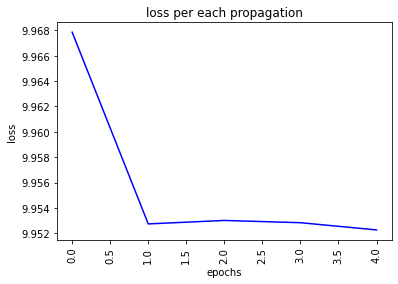

In [461]:
plt.plot(losses, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per each propagation")
plt.show()

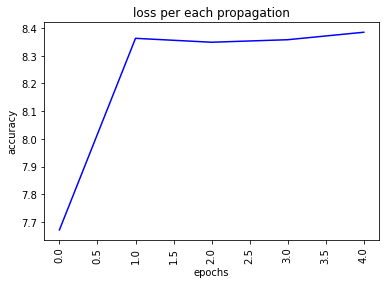

In [462]:
plt.plot(accs, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("loss per each propagation")
plt.show()

##Generation

In [463]:
X1 = train_data[:,0,:].reshape((49608,30))
y1 = train_data[:,1,:].reshape((49608,30))

X1 = torch.from_numpy(X1)
y1 = torch.from_numpy(y1)

train_dataset1 = TensorDataset(X1, y1)
train_dataloader1 = DataLoader(train_dataset1, batch_size=1, shuffle=True)

In [464]:
m= ["چو آفتاب روز آمدش بر میان","پدیدار شد رزم آن شیردلان"]
m[0],m[1] = tokenizer.tokenize(m[0]), tokenizer.tokenize(m[1])

In [465]:
m[0],m[1] = np.array(tokenizer.convert_tokens_to_ids(m[0])),np.array(tokenizer.convert_tokens_to_ids(m[1]))

In [466]:
n = np.concatenate((m[0],[0,0,0,0,0,0,0,15],m[1],[0,0,0,0,0,0,0,0,9]))

In [467]:
model.eval()
outputs = model(torch.tensor(n.reshape(30,1),device=device),torch.tensor(n.reshape(30,1),device=device),teacher_force_ratio=0.0)
outputs = torch.argmax(outputs.reshape(30,25000),dim = 1)
print(tokenizer.decode(outputs))

<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و


In [471]:
counter = 0
for sample_x, sample_y in train_dataloader1:
  x = sample_x.T.to(device)
  y= sample_y.T.to(device)
  #tokenizer.decode(sample_y.reshape(30,1))
  output = model(x,y,teacher_force_ratio=0.0)
  output = torch.argmax(output.reshape(30,25000),dim = 1)
  print(tokenizer.decode(output))
  counter+=1
  if counter ==6 :
    break

<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
<unk> و و و و و و و و و و و و و و و و و و و و و و و و و و و و و
